In [ ]:
import pandas as pd
import numpy as np

raw_data_file = "../data/SF2024.csv"

df = pd.read_csv(raw_data_file)
print("Dataset Loaded Successfully!\n")
print("Basic Info:\n", df.info())

Dataset Loaded Successfully!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       2200 non-null   int64  
 1   P                       2200 non-null   int64  
 2   K                       2200 non-null   int64  
 3   temperature             2200 non-null   float64
 4   humidity                2200 non-null   float64
 5   ph                      2200 non-null   float64
 6   rainfall                2200 non-null   float64
 7   label                   2200 non-null   object 
 8   soil_moisture           2200 non-null   float64
 9   soil_type               2200 non-null   int64  
 10  sunlight_exposure       2200 non-null   float64
 11  wind_speed              2200 non-null   float64
 12  co2_concentration       2200 non-null   float64
 13  organic_matter          2200 non-null   float64
 14  irrigation

In [4]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 N                         0
P                         0
K                         0
temperature               0
humidity                  0
ph                        0
rainfall                  0
label                     0
soil_moisture             0
soil_type                 0
sunlight_exposure         0
wind_speed                0
co2_concentration         0
organic_matter            0
irrigation_frequency      0
crop_density              0
pest_pressure             0
fertilizer_usage          0
growth_stage              0
urban_area_proximity      0
water_source_type         0
frost_risk                0
water_usage_efficiency    0
dtype: int64



Dataset Statistics:
                  N            P            K  temperature     humidity  \
count  2200.000000  2200.000000  2200.000000  2200.000000  2200.000000   
mean     50.551818    53.362727    48.149091    25.616244    71.481779   
std      36.917334    32.985883    50.647931     5.063749    22.263812   
min       0.000000     5.000000     5.000000     8.825675    14.258040   
25%      21.000000    28.000000    20.000000    22.769375    60.261953   
50%      37.000000    51.000000    32.000000    25.598693    80.473146   
75%      84.250000    68.000000    49.000000    28.561654    89.948771   
max     140.000000   145.000000   205.000000    43.675493    99.981876   

                ph     rainfall  soil_moisture    soil_type  \
count  2200.000000  2200.000000    2200.000000  2200.000000   
mean      6.469480   103.463655      20.151388     1.991364   
std       0.773938    54.958389       5.793720     0.812263   
min       3.504752    20.211267      10.024260     1.000000

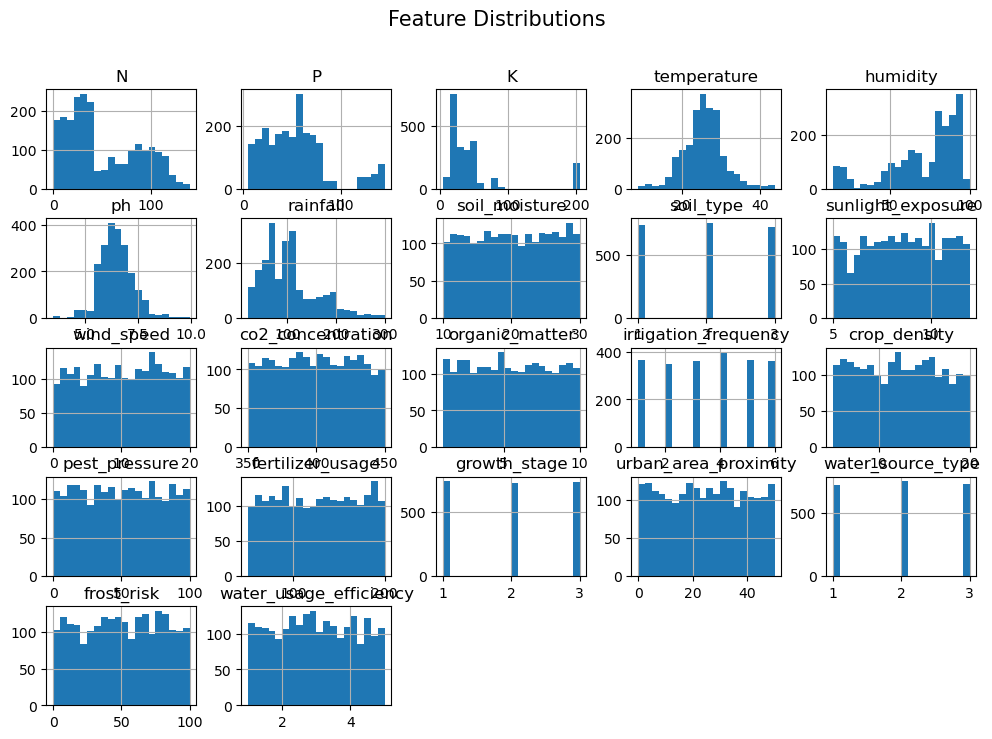

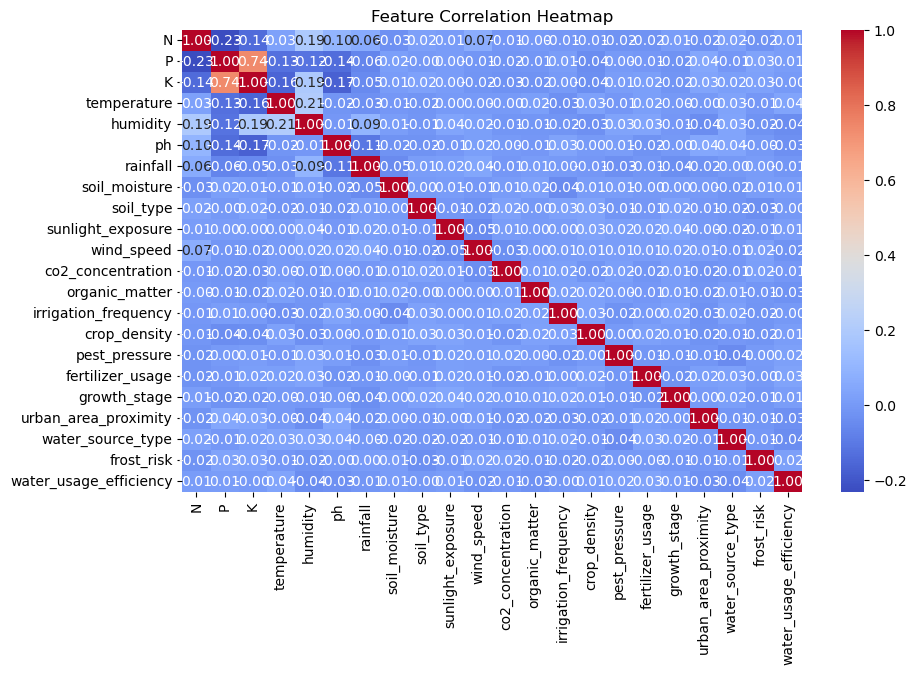

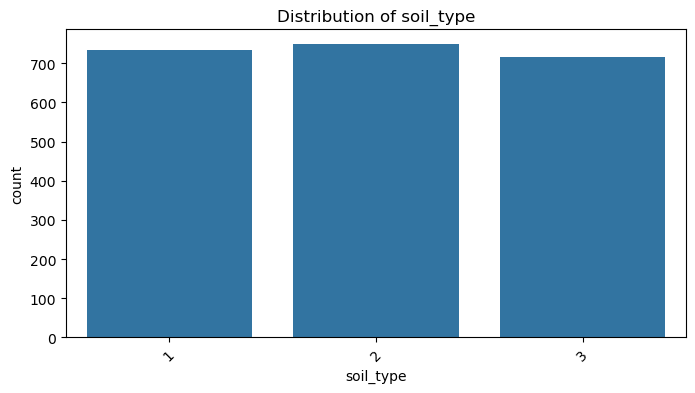

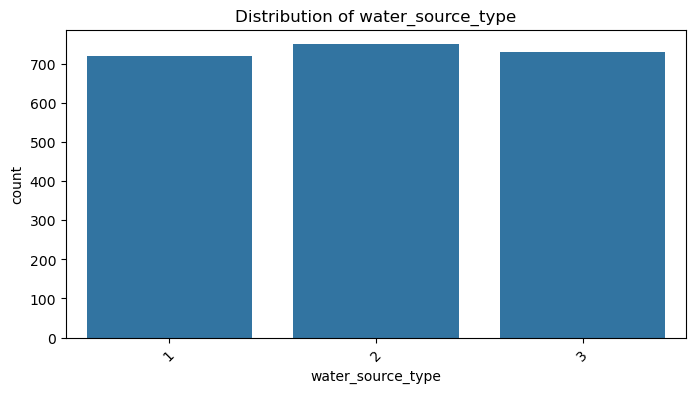

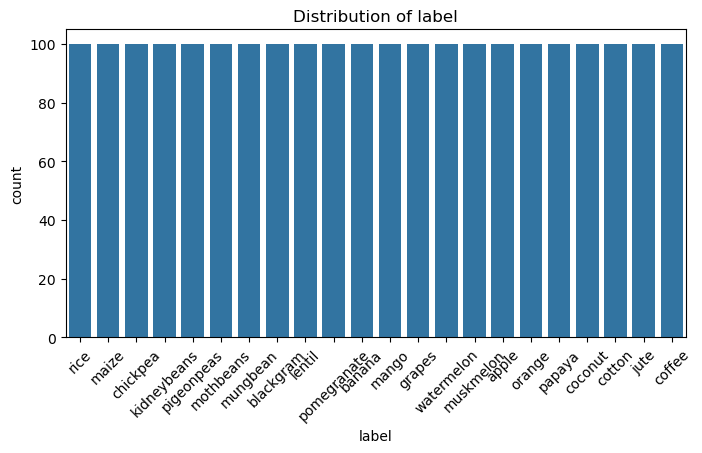

In [7]:
# Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt

print("\nDataset Statistics:\n", df.describe())
    
print("\nDataset Statistics:\n", df.describe())

# Visualizing Feature Distributions (Only Numeric Columns)
numeric_df = df.select_dtypes(include=[np.number])
numeric_df.hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions", fontsize=15)
plt.show()

# Correlation Matrix (Only Numeric Features)
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

# Count plot for categorical variables
categorical_cols = ['soil_type', 'water_source_type', 'label']
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col])
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

# Inferences from Feature Distributions

The histogram plot shows the distribution of numerical features in the dataset. Here are the key insights:

### Skewed Distributions (Non-Normal)

Features like N (Nitrogen), P (Phosphorus), K (Potassium), and CO2 concentration exhibit right-skewed distributions, meaning most values are low, but some are very high.
This suggests outliers or non-uniform nutrient availability in the soil.
Solution: Consider log transformation or scaling to handle skewness.

### Bimodal or Multi-Peaked Distributions

Temperature and Humidity have multi-modal distributions, meaning they vary significantly across different conditions.
This might indicate data from different climatic zones or seasonal variations.

### Categorical Features Appearing as Numeric

Features like soil type, growth stage, and water source type have a few distinct values, indicating they are categorical rather than continuous.
Solution: These need encoding (e.g., One-Hot Encoding or Label Encoding).

### Uniformly Distributed Features

Some features, such as pest pressure, frost risk, and crop density, appear to have a nearly uniform distribution.
This suggests that these parameters were evenly sampled across different conditions.

### Possible Data Issues

Soil moisture shows some extreme values, possibly indicating sensor errors or missing data imputation issues.
Irrigation frequency and fertilizer usage seem to have discrete jumps, which should be further analyzed.

# Inferences from the Correlation Heatmap

### Strong Correlation within NPK (N, P, K)

Nitrogen (N) and Phosphorus (P) have a positive correlation (~0.23).
Phosphorus (P) and Potassium (K) also show a moderate correlation (~0.74), indicating they might often be present together in similar proportions in the soil.

### Temperature vs. Humidity

There is a mild negative correlation between temperature and humidity (~-0.19), which makes sense because higher temperatures often reduce humidity levels.

### pH and Rainfall

Soil pH has a slight correlation with rainfall (~0.11), possibly indicating that regions with more rainfall might have more neutral to acidic soils.

### Wind Speed & CO₂ Concentration

Wind Speed and CO₂ Concentration are mildly correlated (~0.05), possibly due to wind dispersing CO₂ levels in the atmosphere.
Low Correlation for Some Features

### Independent Features

Many features (e.g., urban area proximity, water source type, pest pressure) show very low correlation values (< 0.1) with other features.
This suggests that these factors are relatively independent of other environmental and soil parameters.

### Irrigation & Fertilizer Usage

There is no strong direct correlation between irrigation frequency and soil moisture, meaning that irrigation is likely dependent on additional factors such as rainfall or crop type.

Fertilizer usage does not show strong correlations with N, P, K levels, suggesting that fertilization is based on external decision factors beyond just soil nutrient content.

### Key Takeaways

- Strong relationships between N, P, K indicate that fertilizer recommendations might be impacted by their combined balance rather than individual values.
- Soil and climate interactions (temperature-humidity, pH-rainfall) suggest potential influences on crop suitability.
- The lack of strong correlation in some areas suggests that additional derived features (e.g., Nutrient Balance Ratio, Water Availability Index) might be necessary to capture complex relationships.

In [10]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, PowerTransformer
from sklearn.feature_selection import SelectKBest, f_classif

# Identify Skewed Features
def identify_skewed_features(df, threshold=0.5):
    skewed_features = df.select_dtypes(include=['number']).apply(lambda x: x.skew()).sort_values(ascending=False)
    return skewed_features[abs(skewed_features) > threshold].index.tolist()

# Feature Selection
def select_features(X, y, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Selected Features: {selected_features}")
    return X_selected, selected_features

# Create Irrigation Need Column
def create_irrigation_need(df):
    df['Irrigation_Need'] = ((df['soil_moisture'] < 30) &
                              ((df['temperature'] > 30) | (df['humidity'] < 50) | 
                               (df['Water_Availability_Index'] < 0.5) | 
                               (df['irrigation_frequency'] > 3) | 
                               (df['Water_Usage_Efficiency'] < 1)))  # Adjust threshold as needed
    df['Irrigation_Need'] = df['Irrigation_Need'].astype(int)
    print("Irrigation Need column updated successfully!")
    return df

# Data Preprocessing
def preprocess_data(df):
    # Fill missing values
    for col in df.select_dtypes(include=['number']).columns:
        df[col].fillna(df[col].median(), inplace=True)
    for col in df.select_dtypes(include=['object']).columns:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    # Encode categorical features
    label_encoders = {}
    categorical_cols = ['soil_type', 'water_source_type']  # Update with actual categorical columns
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    
    # Handle Skewness using Power Transformation
    skewed_cols = identify_skewed_features(df)
    if skewed_cols:
        pt = PowerTransformer(method='yeo-johnson')  # Works for both positive and negative values
        df[skewed_cols] = pt.fit_transform(df[skewed_cols])
        print(f"Applied Power Transformation to skewed features: {skewed_cols}")
    
    # Normalize numerical features
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    scaler = StandardScaler()
    df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    
    print("Preprocessing Completed!\n")
    return df, label_encoders, scaler

df_processed, encoders, scaler = preprocess_data(df)

processes_data_file = "../data/SF2024_processed.csv"
df_processed.to_csv(processes_data_file, index=False)
print("Processed data saved successfully!")
print("Processed Data Info:\n", df_processed.info())

Preprocessing Completed!

Processed data saved successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   N                       2200 non-null   float64
 1   P                       2200 non-null   float64
 2   K                       2200 non-null   float64
 3   temperature             2200 non-null   float64
 4   humidity                2200 non-null   float64
 5   ph                      2200 non-null   float64
 6   rainfall                2200 non-null   float64
 7   label                   2200 non-null   object 
 8   soil_moisture           2200 non-null   float64
 9   soil_type               2200 non-null   float64
 10  sunlight_exposure       2200 non-null   float64
 11  wind_speed              2200 non-null   float64
 12  co2_concentration       2200 non-null   float64
 13  organic_matter          2200 non

C:\Users\anshu\AppData\Local\Temp\ipykernel_17276\3492132890.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\anshu\AppData\Local\Temp\ipykernel_17276\3492132890.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa